In [1]:
import utils.rfi.sat_sim.satellite_simulations as ss
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from skyfield.api import load as sf_load

In [3]:
from skyfield.api import Topos, Star
from skyfield.positionlib import ICRF, Angle

In [4]:
import pytz
from tzwhere import tzwhere

In [5]:
tzwhere = tzwhere.tzwhere()

In [6]:
def get_dist_and_seps(sat_tles, ant_locs, times, target):
    
    ants = [Topos(latitude_degrees=ant_locs[i,0], longitude_degrees=ant_locs[i,1],
                elevation_m=ant_locs[i,2]) for i in range(len(ant_locs))]
    
    ts = sf_load.timescale()
    t = ts.utc(times)
    
    el_dist_ra_dec_sep = np.zeros((len(times), len(ants), len(sat_tles), 5))
    
    for i, sat_tle in enumerate(sat_tles): 
        for j, ant in enumerate(ants):
            topocentric = (sat_tle-ant).at(t)
            el = topocentric.altaz()[0].degrees
            dist = topocentric.altaz()[2].m
            ra = topocentric.radec()[0]._degrees
            dec = topocentric.radec()[1]._degrees
            el_dist_ra_dec_sep[:,j,i,:4] = np.array([el, dist, ra, dec]).T
    
    ra, dec = el_dist_ra_dec_sep[:,:,:,2], el_dist_ra_dec_sep[:,:,:,3]
    el_dist_ra_dec_sep[:,:,:,-1] = angular_separation(ra, dec, target)
    
    return el_dist_ra_dec_sep

In [7]:
def angular_separation(ra, dec, phase_centre):
    """
    Calculates the angular separation between a source and the phase centre.

    Parameters
    ----------
    ra : float
        Right-ascension of the source in degrees.
    dec : float
        Declination of the source in degrees.
    phase_centre : tuple
        Right-ascension and declination of the phase centre in degrees.

    Returns
    ------
    theta : float
        The angular separation between the phase centre and given source in
        degrees.
    """
    ra1, dec1 = np.deg2rad([ra, dec])
    ra2, dec2 = np.deg2rad(phase_centre)

    theta = np.arccos(np.sin(dec1)*np.sin(dec2) + \
            np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2))

    return np.rad2deg(theta)

In [8]:
def phase_delays(distances, freqs):
    """
    Calculate the phase delay terms, K.
    
    Parameters:
    -----------
    distances: np.array (n_time,n_ant,n_src)
        Distances between each source and antenna.
    freqs: np.array (n_freq,)
        Frequencies
        
    Returns:
    --------
    delays: np.array (n_time,n_freq,n_bl,n_src)
        Phase delay terms.
    """
    
    c = 2.99792458e8
    phases = freqs[None,:,None,None]*(distances[:,None,:,:]-distances[:,None,:,:])/c
    
    return np.exp(1.j*phases)

In [9]:
def sinc_beam(ang_sep, params):
    """
    A sinc beam that narrows with increasing frequency.
    A parameter $\alpha \propto D$ is present to control
    the width of the beam.

    Paramters:
    ----------
    ang_sep: np.array (n_time,n_ant,n_srcs)
        The radius at which to evaluate the beam function.
        Angular separation, in degrees, from the pointing direction.
    params: array-like (2,)
        Contains alpha, the width parameter, proportional to the
        dish diameter. And the frequency. (alpha, freq)

    Returns:
    --------
    beam: np.array (n_time,n_freqs,n_ant,n_srcs)
        The attenuation due to the beam at the given angular separation.
    """

    alpha, freq = params
    a = 3e-2
    b = 2*np.pi/123 
    phi = 320
    beam = np.exp(-1j*(freq[None,:,None,None]*b - phi))*np.sinc(a*freq[None,:,None,None]*ang_sep[:,None,:,:])
#     beam = np.sinc(alpha*freq[None,:,None,None]*ang_sep[:,None,:,:])

    return beam

In [10]:
def auto_beam(ll, mm, ff, a=3e-2, b=2*np.pi/123, phi=320):
    """
    Generate the complex beam cube for the auto-polarizations (HH, VV).

    Parameters
    ----------
    ll : ndarray
        Array of shape (channels, resolution, resolution) containing the l
        coordinate points varying along axis 1.
    mm : ndarray
        Array of shape (channels, resolution, resolution) containing the m
        coordinate points varying along axis 2.
    ff : ndarray
        Array of shape (channels, resolution, resolution) containing the
        frequency coordinate points varying along axis 0.
    a : float
        Width of the sinc component of the beam.
    b : float
        Oscillatory frequency of the complex exponential component.
    phi : float
        Phase offset in the complex exponential component in degrees.

    Returns
    -------
    beam : ndarray
        Array of shape (channels, resolution, resolution) containing the
        complex values of the beam sensitivity.
    """
    phi = np.deg2rad(phi)
    rr = np.sqrt(ll**2+mm**2)
    beam = np.exp(-1j*(ff*b - phi))*np.sinc(a*rr*ff)

    return beam

In [11]:
def cross_beam(ll, mm, ff, a=2.5e-2, b=3e-2):
    """
    Generate the complex beam cube for the cross-polarizations (HV, VH).

    Parameters
    ----------
    ll : ndarray
        Array of shape (channels, resolution, resolution) containing the l
        coordinate points varying along axis 1.
    mm : ndarray
        Array of shape (channels, resolution, resolution) containing the m
        coordinate points varying along axis 2.
    ff : ndarray
        Array of shape (channels, resolution, resolution) containing the
        frequency coordinate points varying along axis 0.
    a : float
        Width of the sinc component of the beam.
    b : float
        Characteristic distance of the exponential dropoff component.

    Returns
    -------
    beam : ndarray
        Array of shape (channels, resolution, resolution) containing the
        complex values of the beam sensitivity.
    """
    rr = np.sqrt(ll**2+mm**2)
    lam = 2*np.pi/123
    phi = np.deg2rad(140-180)
    # sig = [1.2e-1, 1e-3, 1410, 4e-4]
    # sigmoid = (sig[1]/(1+np.exp(-(sig[0]*(ff-sig[2])))) + sig[3])
    freq_dep = np.exp(-1j*(lam*ff-phi))#*sigmoid
    beam = -ll*mm*np.sinc(a*rr*ff)*np.exp(-(rr/b)**2)*freq_dep

    return beam

In [12]:
def RIME(B, K, E, G):
    """
    Calculate the RIME for a given birghtness matrix, 
    phase delay matrix and direction dependent effects. 
    
    Parameters:
    -----------
    B: np.array (2,2,n_time,n_freq,n_src)
        The brightness tensor.
    K: np.array (n_time,n_freq,n_ant,n_src)
        The phase delay tensor.
    E: np.array (2,2,n_time,n_freq,n_ant,n_src)
        The direction dependent effects tensor.
    G: np.array (2,2,n_time,n_freq,n_ant)
        The direction independent effects.
        
    Returns:
    --------
    V: np.array (2,2,n_time,n_freq,n_bl)
        The visibilies tensor. n_bl = n_ant*(n_ant-1)/2
    """
    
    a1, a2 = np.triu_indices(K.shape[-2], 1)
    
#     Source coherency tensor
    X = B[:,:,:,:,None,:]*K[None,None,:,:,a1,:]*np.conjugate(K[None,None,:,:,a2,:])
    
#     Apparent source coherency
    A = np.einsum(('iAtfbs,ABtfbs,jBtfbs->ijtfbs'), E[...,a1,:], X, 
                  np.conjugate(E[...,a2,:]), optimize='optimal')
    
#     Visibilities
    V = np.einsum('iAtfb,ABtfbs,jBtfb->ijtfb', G[...,a1], A, 
                  np.conjugate(G[...,a2]), optimize='optimal')
    
    return V

# Define a telescope: location (lat, lon), layout

In [13]:
MeerKAT_gps = [-30.712987, 21.442995, 1049.0]    # Latitude (d), Longitude(d), Elevation (m)

In [14]:
enu = np.loadtxt('utils/telescope/uv_sim/MeerKAT.enu.txt')[:8]

In [15]:
gps_ants = ss.enu_to_gps_el(MeerKAT_gps[:2], enu)
gps_ants[:,2] += MeerKAT_gps[2]

In [16]:
telescope_tz = pytz.timezone(tzwhere.tzNameAt(*MeerKAT_gps[:2]))

In [17]:
freqs = np.loadtxt('utils/telescope/bandpass/MeerKAT_L-Band_Frequencies.csv')

In [18]:
freqs = freqs[:4096]
n_freq = len(freqs)

# Define an observation period 

In [19]:
start_obs_utc = datetime.datetime(2019, 7, 24, 12, 0, 0)
start_obs = telescope_tz.localize(start_obs_utc)
one_min = datetime.timedelta(minutes=1)
one_hour = datetime.timedelta(hours=1)
one_day = datetime.timedelta(days=1)
obs_time = datetime.timedelta(seconds=800)
int_time = datetime.timedelta(seconds=1)

In [20]:
n_time = int(obs_time/int_time)

# Define a target (RA, DEC)

In [21]:
ra, dec = [24.0, -30.0]

# Get satellite positions

In [22]:
tles = sf_load.tle(ss.get_archival_tles(start_obs_utc-one_day, start_obs_utc+one_day))

File 2019-07-23.tle exists and is readable.


## Get positions of all satellites @ start, middle, end

In [23]:
obs_times = [start_obs+i*0.5*obs_time for i in range(3)]

In [24]:
%%time
el_dist_ra_dec_sep = get_dist_and_seps(list(tles.values()), gps_ants, obs_times, [ra, dec])

CPU times: user 3.09 s, sys: 8 ms, total: 3.1 s
Wall time: 3.1 s


In [25]:
means = np.mean(el_dist_ra_dec_sep, axis=(0,1), keepdims=True)
selected_sats = np.where((means[:,:,:,0]>0) & (means[:,:,:,-1]<30))[2]

In [26]:
selected_sat_ids = np.array(list(tles.keys()))[selected_sats].astype(int)
selected_tles = [tles[i] for i in selected_sat_ids]

In [27]:
selected_sat_ids

array([22877, 32275, 37753, 41861, 37829, 37846])

## Selection made based on 
### 1. Mean elevation > 0
### 2. Mean separation < 30

In [28]:
obs_times = [start_obs+i*int_time for i in range(int(obs_time/int_time))]

In [29]:
%%time
el_dist_ra_dec_sep = get_dist_and_seps(selected_tles, gps_ants, obs_times, [ra,dec])

CPU times: user 4.02 s, sys: 5.86 s, total: 9.88 s
Wall time: 2.25 s


In [30]:
el_dist_ra_dec_sep.shape

(800, 8, 6, 5)

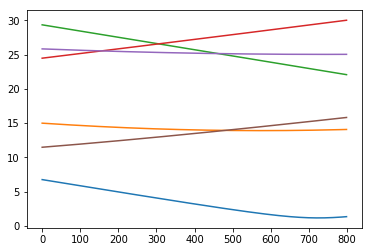

In [31]:
plt.plot(el_dist_ra_dec_sep[:,0,:,-1]);

In [32]:
n_rfi = el_dist_ra_dec_sep.shape[-2]

# Calculate beam matrix

In [33]:
from utils.rfi.rfi_spectra.sim_rfi_spectra import get_rfi_spectra

In [34]:
n_rfi

6

In [35]:
rfi_spectra = np.transpose(get_rfi_spectra(n_freq, n_rfi, n_time), (3,1,2,0))

In [36]:
rfi_spectra.shape

(4, 800, 4096, 6)

In [37]:
B = ss.brightness_matrix(rfi_spectra[0], rfi_spectra[1], rfi_spectra[2], rfi_spectra[3])

In [38]:
# RFI_intensity = 1e6
# rfi_I = RFI_intensity*np.ones((n_time, n_freq, n_rfi))
# rfi_Q = RFI_intensity*np.zeros_like(rfi_I)
# rfi_U = np.zeros_like(rfi_I)
# rfi_V = np.zeros_like(rfi_I)

In [39]:
# B = ss.brightness_matrix(rfi_I, rfi_Q, rfi_U, rfi_V)

In [40]:
B.shape

(2, 2, 800, 4096, 6)

# Calculate phase delays

In [41]:
el_dist_ra_dec_sep.shape

(800, 8, 6, 5)

In [42]:
K = phase_delays(el_dist_ra_dec_sep[...,1], freqs)

In [43]:
K.shape

(800, 4096, 8, 6)

In [44]:
n_time, n_freq, n_ant, n_rfi = K.shape

# Calculate direction dependent effects

In [45]:
E = ss.pol_beam(auto_beam=sinc_beam, cross_beam=None, params=[2.e-8, freqs], 
                ang_sep=el_dist_ra_dec_sep[...,-1])

In [46]:
E.shape

(2, 2, 800, 4096, 8, 6)

# Calculate direction independent effects

In [47]:
bandpass = np.transpose(np.load('utils/telescope/bandpass/MeerKAT_Bandpass_HH-HV-VH-VV.npy'), 
                        (3,0,2,1))[...,:n_ant]

In [48]:
bandpass.shape

(4, 1, 4096, 8)

In [49]:
G = np.zeros((2,2,n_time,n_freq,n_ant))
G[0,0] = bandpass[0]
G[0,1] = bandpass[1]
G[1,0] = bandpass[2]
G[1,1] = bandpass[3]

In [50]:
G.shape

(2, 2, 800, 4096, 8)

In [51]:
# G = 1e3*np.ones((2,2,n_time,n_freq,n_ant))
# G[0,1] = 0.
# G[1,0] = 0.

# Calculate visibilities

In [52]:
16*496*800*2048*2*2/1e9

52.0093696

In [ ]:
%%time
V = RIME(B, K, E, G)

In [ ]:
plt.plot(freqs/1e6, 10*np.log10(np.abs(V[0,0,0,:,0])))

In [ ]:
plt.plot(freqs/1e6, 10*np.log10(np.abs(V[0,0,0,:,0])))

In [ ]:
plt.plot(freqs, np.abs(sinc_beam(20*np.ones((1,1,1)), [2e-8, freqs])[0,:,0,0]))

In [ ]:
# plt.plot(sinc_beam([0,], [2, freqs]))

In [ ]:
plt.plot(np.abs(V[0,0,0,:]));

In [ ]:
# ss.sinc_beam()